In [ ]:
from google.colab import drive
drive.mount('/content/drive')          # 3‑second OAuth prompt


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import files


In [ ]:
DATA_PATH = "/content/drive/My Drive/dateset/202402_Copy.xlsx"   # ← your folder
df = pd.read_excel(DATA_PATH)

# quick check
print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/dateset/202402_Copy.xlsx'

Model Performance (Predicting ARR YoY Growth for Q1–Q4):
MAE: 0.10 | R² Score: 0.79
Q1 R² Score: 0.79
Q2 R² Score: 0.82
Q3 R² Score: 0.77
Q4 R² Score: 0.75


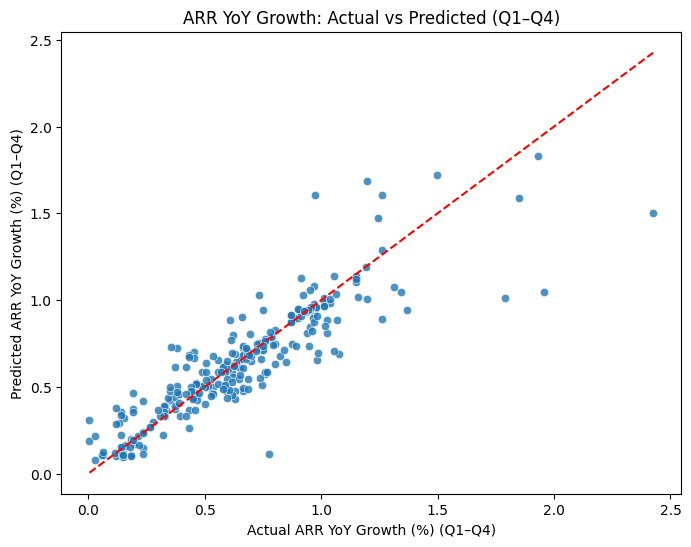

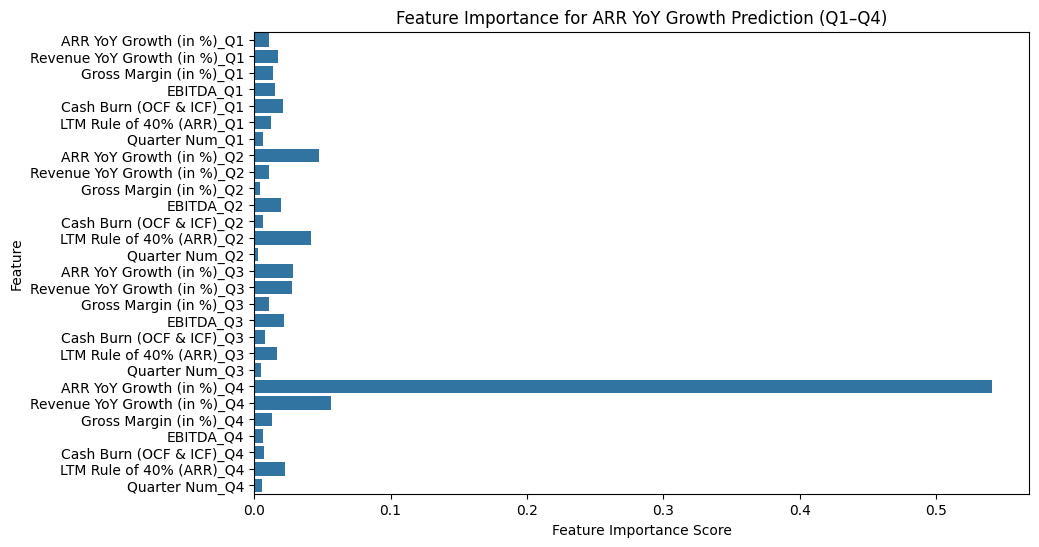

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel(file2024)  # Replace with your actual path

# Ensure correct quarter order
df['Year'] = df['Financial Quarter'].str.extract(r'FY(\d{2,4})')[0].astype(int)
df['Year'] = df['Year'].apply(lambda x: x + 2000 if x < 100 else x)
df['Quarter Num'] = df['Financial Quarter'].str.extract(r'(Q[1-4])')[0].map({'Q1':1,'Q2':2,'Q3':3,'Q4':4})
df['Quarter Order'] = (df['Year'] - 2000) * 4 + df['Quarter Num']
df = df.sort_values(by=['id_company', 'Quarter Order']).reset_index(drop=True)

# Filter for ARR 1M - 10M
df['New ARR'] = df['New ARR'] * 1_000
df_filtered = df[(df['New ARR'] >= 1_000_000) & (df['New ARR'] <= 10_000_000)].copy()

# Select relevant features
selected_columns = ['id_company', 'Quarter Order', 'ARR YoY Growth (in %)',
                    'Revenue YoY Growth (in %)', 'Gross Margin (in %)',
                    'EBITDA', 'Cash Burn (OCF & ICF)', 'LTM Rule of 40% (ARR)', 'Quarter Num']
df_filtered = df_filtered[selected_columns].copy()

# Fill NaNs with median per company
for col in df_filtered.columns:
    if col not in ['id_company', 'Quarter Order']:
        df_filtered[col] = df_filtered.groupby('id_company')[col].transform(lambda x: x.fillna(x.median()))

# Create time-series dataset (4 past quarters → predict next 4)
sequence_length = 4
data = []

for company in df_filtered['id_company'].unique():
    company_data = df_filtered[df_filtered['id_company'] == company].reset_index(drop=True)

    for i in range(len(company_data) - sequence_length - 3):  # Ensure 4 future quarters
        past_quarters = company_data.iloc[i:i+sequence_length]
        next_4 = company_data.iloc[i+sequence_length:i+sequence_length+4]

        row = list(past_quarters.drop(columns=['id_company', 'Quarter Order']).values.flatten())
        row.extend(next_4['ARR YoY Growth (in %)'].values)
        data.append(row)

# Convert to DataFrame
target_columns = ['Target_ARR_Q1', 'Target_ARR_Q2', 'Target_ARR_Q3', 'Target_ARR_Q4']
input_features = df_filtered.columns[2:]  # Exclude id_company, Quarter Order
columns = [f"{col}_Q{i+1}" for i in range(sequence_length) for col in input_features] + target_columns
df_timeseries = pd.DataFrame(data, columns=columns)

# Separate features and targets
X = df_timeseries.drop(columns=target_columns).select_dtypes(include=['number'])
Y = df_timeseries[target_columns]

# Train/Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train MultiOutput XGBoost Regressor
model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42))
model.fit(X_train, Y_train)


# Predictions & Evaluation
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test.values.flatten(), Y_pred.flatten())
r2 = r2_score(Y_test.values.flatten(), Y_pred.flatten())
print(f"Model Performance (Predicting ARR YoY Growth for Q1–Q4):\nMAE: {mae:.2f} | R² Score: {r2:.2f}")

for i, quarter in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    r2_q = r2_score(Y_test.values[:, i], Y_pred[:, i])
    print(f"{quarter} R² Score: {r2_q:.2f}")

# Visualization: Actual vs. Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test.values.flatten(), y=Y_pred.flatten(), alpha=0.8)
plt.plot([Y_test.values.min(), Y_test.values.max()],
         [Y_test.values.min(), Y_test.values.max()], linestyle='--', color='red')
plt.xlabel("Actual ARR YoY Growth (%) (Q1–Q4)")
plt.ylabel("Predicted ARR YoY Growth (%) (Q1–Q4)")
plt.title("ARR YoY Growth: Actual vs Predicted (Q1–Q4)")
plt.show()

# Feature importance: average across XGBoost models
feature_importance = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=X.columns)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for ARR YoY Growth Prediction (Q1–Q4)")
plt.show()


# Predict ARR YoY Growth (Next 4 Quarters) with Median Imputation using **Random Forest Regressor**

Unique Companies in Training Set: 277
Unique Companies in Testing Set: 70
Model Performance (Predicting ARR YoY Growth for Q1–Q4):
MAE: 0.10 | R² Score: 0.82
Q1 R² Score: 0.87
Q2 R² Score: 0.87
Q3 R² Score: 0.79
Q4 R² Score: 0.72


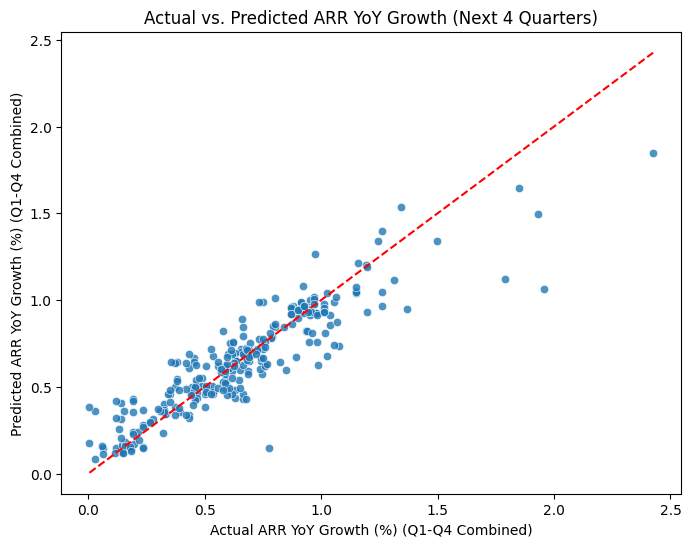

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel(file2024)  # Replace with your actual file variable

# Ensure correct quarter order
df['Year'] = df['Financial Quarter'].str.extract(r'FY(\d{2,4})')[0].astype(int)
df['Year'] = df['Year'].apply(lambda x: x + 2000 if x < 100 else x)
df['Quarter Num'] = df['Financial Quarter'].str.extract(r'(Q[1-4])')[0]
quarter_mapping = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
df['Quarter Num'] = df['Quarter Num'].map(quarter_mapping)
df['Quarter Order'] = (df['Year'] - 2000) * 4 + df['Quarter Num']
df = df.sort_values(by=['id_company', 'Quarter Order']).reset_index(drop=True)

# Filter for ARR 1M - 10M
df['New ARR'] = df['New ARR'] * 1_000  # Convert ARR to dollars
df_filtered = df[(df['New ARR'] >= 1_000_000) & (df['New ARR'] <= 10_000_000)].copy()

# Select relevant metrics
selected_columns = ['id_company', 'Quarter Order', 'ARR YoY Growth (in %)',
                    'Revenue YoY Growth (in %)', 'Gross Margin (in %)',
                    'EBITDA', 'Cash Burn (OCF & ICF)', 'LTM Rule of 40% (ARR)', 'Quarter Num']
df_filtered = df_filtered[selected_columns].copy()

# Fill missing values using median per company
for col in df_filtered.columns:
    if col not in ['id_company', 'Quarter Order']:
        df_filtered[col] = df_filtered.groupby('id_company')[col].transform(lambda x: x.fillna(x.median()))

# Create Time-Series Data (4 Past Quarters → Predict Next 4 Quarters)
sequence_length = 4
data = []

for company in df_filtered['id_company'].unique():
    company_data = df_filtered[df_filtered['id_company'] == company].reset_index(drop=True)

    for i in range(len(company_data) - sequence_length - 3):  # Ensure we have 4 future quarters
        past_quarters = company_data.iloc[i:i + sequence_length]
        next_4_quarters = company_data.iloc[i + sequence_length:i + sequence_length + 4]

        row = list(past_quarters.drop(columns=['id_company', 'Quarter Order']).values.flatten())
        row.extend(next_4_quarters['ARR YoY Growth (in %)'].values)  # Targets
        data.append(row)

# Convert to DataFrame
target_columns = ["Target_ARR_Q1", "Target_ARR_Q2", "Target_ARR_Q3", "Target_ARR_Q4"]
columns = [f"{col}_Q{i+1}" for i in range(sequence_length) for col in df_filtered.columns[2:]] + target_columns
df_timeseries_global = pd.DataFrame(data, columns=columns)

# Remove non-numeric columns
X_global = df_timeseries_global.drop(columns=target_columns).select_dtypes(include=['number'])
Y_global = df_timeseries_global[target_columns]

# Encode any remaining object columns (just in case)
for col in X_global.select_dtypes(include=['object']).columns:
    X_global[col] = X_global[col].astype('category').cat.codes

# Train/Test Split
X_train_global, X_test_global, Y_train_global, Y_test_global = train_test_split(
    X_global, Y_global, test_size=0.2, random_state=42
)

# Count unique companies in training and testing sets
unique_train_companies = X_train_global.shape[0]
unique_test_companies = X_test_global.shape[0]
print(f"Unique Companies in Training Set: {unique_train_companies}")
print(f"Unique Companies in Testing Set: {unique_test_companies}")

# Train Multi-Output Random Forest Model
model_global = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model_global.fit(X_train_global, Y_train_global)

# Predictions & Evaluation
Y_pred_global = model_global.predict(X_test_global)

# Calculate overall model performance across all 4 quarters
mae_overall = mean_absolute_error(Y_test_global.values.flatten(), Y_pred_global.flatten())
r2_overall = r2_score(Y_test_global.values.flatten(), Y_pred_global.flatten())
print(f"Model Performance (Predicting ARR YoY Growth for Q1–Q4):")
print(f"MAE: {mae_overall:.2f} | R² Score: {r2_overall:.2f}")

# Per-quarter R² scores
for i, quarter in enumerate(["Q1", "Q2", "Q3", "Q4"]):
    r2_q = r2_score(Y_test_global.values[:, i], Y_pred_global[:, i])
    print(f"{quarter} R² Score: {r2_q:.2f}")

# Unified Visualization: Actual vs. Predicted for All 4 Quarters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_global.values.flatten(), y=Y_pred_global.flatten(), alpha=0.8)
plt.plot([Y_test_global.values.min(), Y_test_global.values.max()],
         [Y_test_global.values.min(), Y_test_global.values.max()], linestyle="--", color="red")
plt.xlabel("Actual ARR YoY Growth (%) (Q1-Q4 Combined)")
plt.ylabel("Predicted ARR YoY Growth (%) (Q1-Q4 Combined)")
plt.title("Actual vs. Predicted ARR YoY Growth (Next 4 Quarters)")
plt.show()



<ipython-input-12-a8f93b475a65>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quarter_names, y=r2_scores, palette="Blues_d")


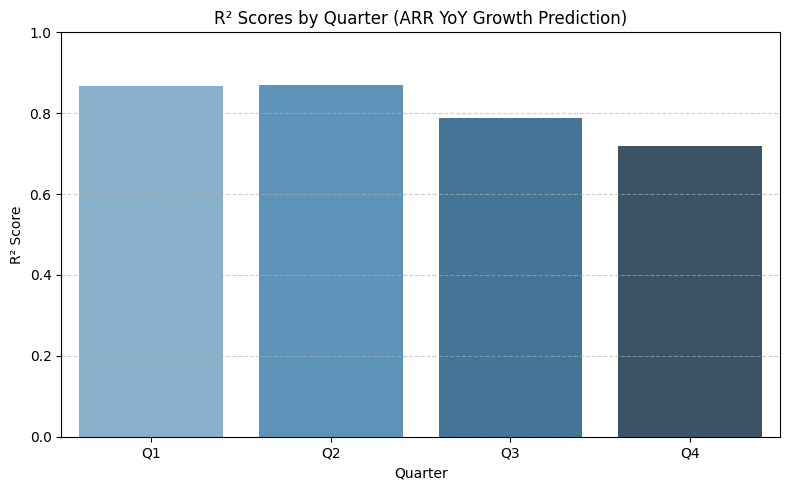

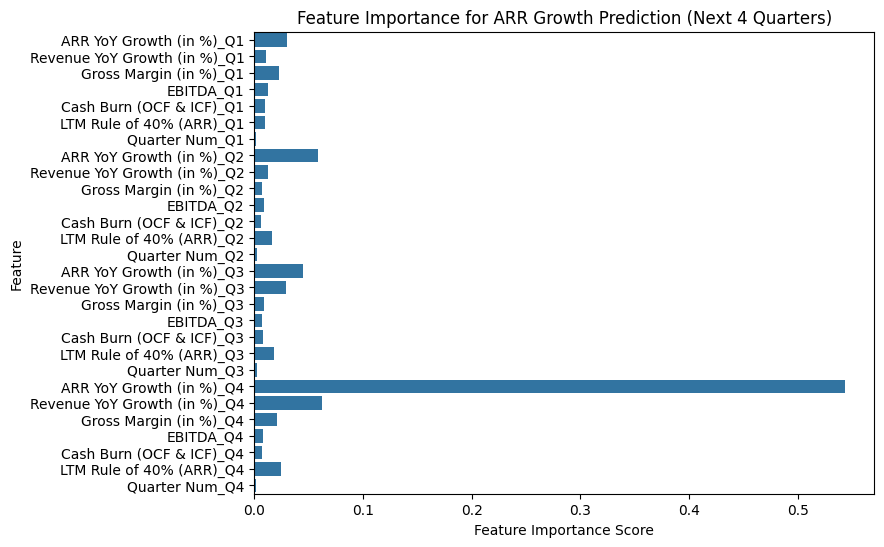

In [ ]:
# Calculate and store per-quarter R² scores
quarter_names = ["Q1", "Q2", "Q3", "Q4"]
r2_scores = []

for i in range(4):
    r2_q = r2_score(Y_test_global.values[:, i], Y_pred_global[:, i])
    r2_scores.append(r2_q)

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=quarter_names, y=r2_scores, palette="Blues_d")
plt.ylim(0, 1)
plt.title("R² Scores by Quarter (ARR YoY Growth Prediction)")
plt.ylabel("R² Score")
plt.xlabel("Quarter")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Feature Importance (Averaged Across All Trees)
feature_importance = np.mean([est.feature_importances_ for est in model_global.estimators_], axis=0)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=X_global.columns)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for ARR Growth Prediction (Next 4 Quarters)")
plt.show()

SHAP (SHapley Additive exPlanations) is a model‑agnostic framework that tells you how much each feature contributes to an individual prediction and to the model overall.

**Core idea — Shapley values:**
It borrows a concept from cooperative game theory where each “player” (feature) gets credit for its marginal contribution to the final “payout” (the model’s output), averaged over all possible feature orderings. This guarantees fairness and additivity.

**Local explanations:**
For a single prediction, SHAP produces a signed value for every feature showing how it pushes the output up or down relative to the model’s baseline. These can be visualised in force/waterfall plots—great for case‑by‑case audits.

**Global importance:**
By aggregating absolute SHAP values across many observations, you get a ranked list of features that the model relies on most—effectively an importance metric with clear directionality.

**Model‑agnostic, fast for trees:**
SHAP works with any black‑box model (via sampling) but offers specialised, efficient algorithms for tree ensembles, linear models, and deep nets, making explanation practical even on large datasets.

Why you’d use it:

* Debug campaigns: spot data leakage or erroneous features.

* Build trust: give stakeholders human‑readable reasons behind predictions.

* Feature selection & drift monitoring: identify which variables matter and detect when importance profiles change over time.

In short, SHAP turns opaque model predictions into a transparent, feature‑by‑feature narrative—both for single cases and at scale.

—— Q1: SHAP feature impact ——


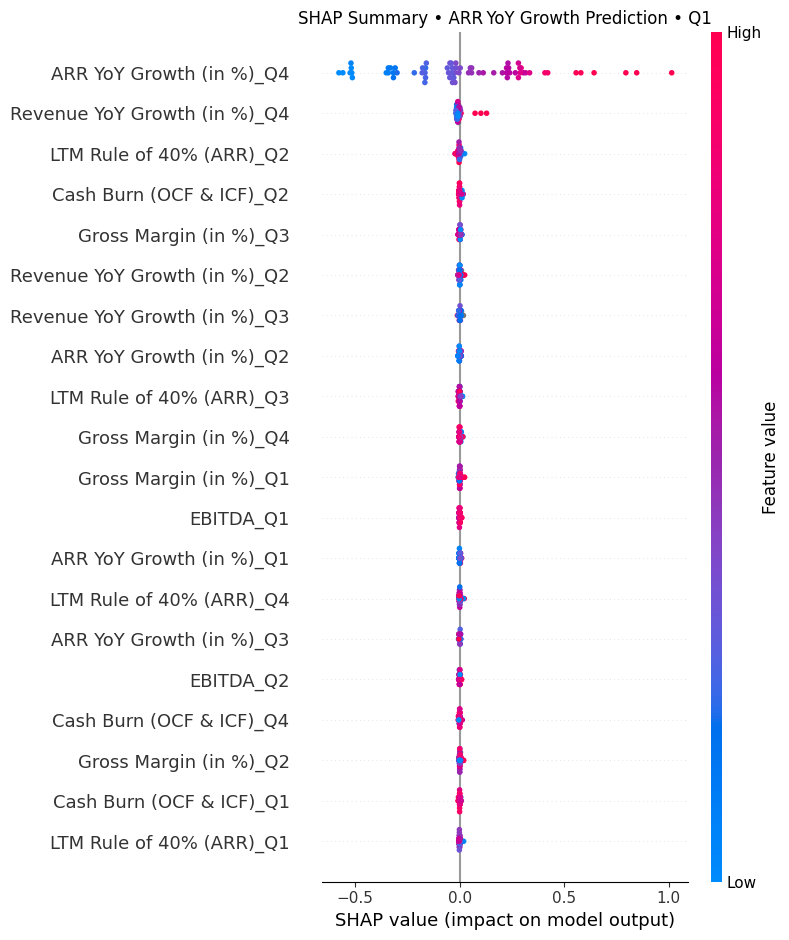

—— Q2: SHAP feature impact ——


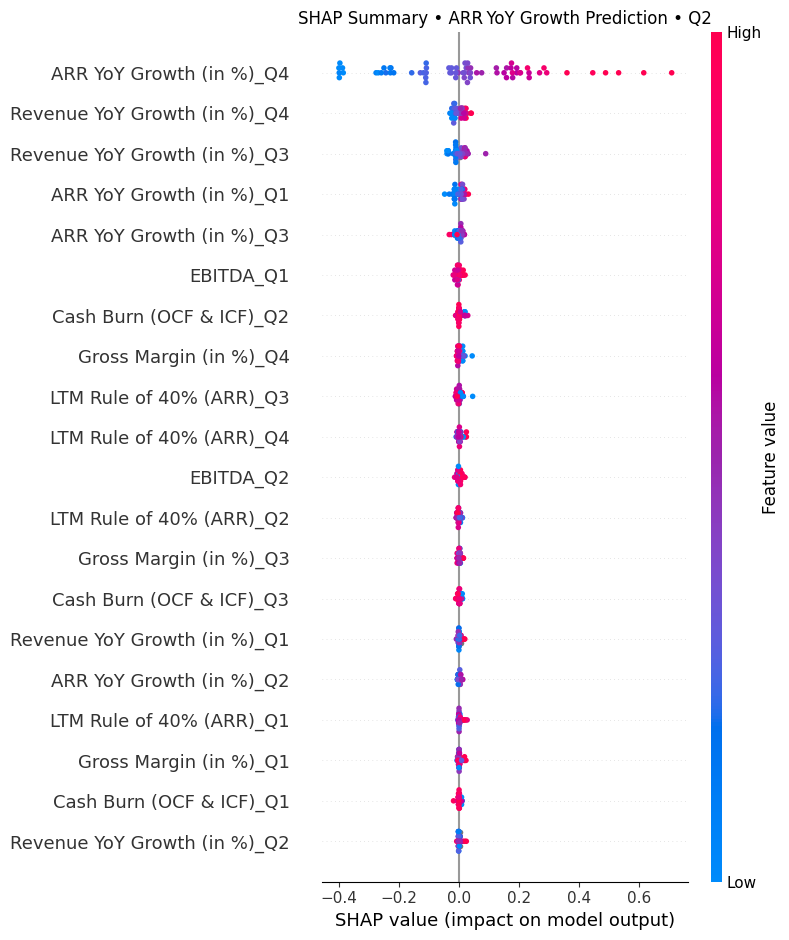

—— Q3: SHAP feature impact ——


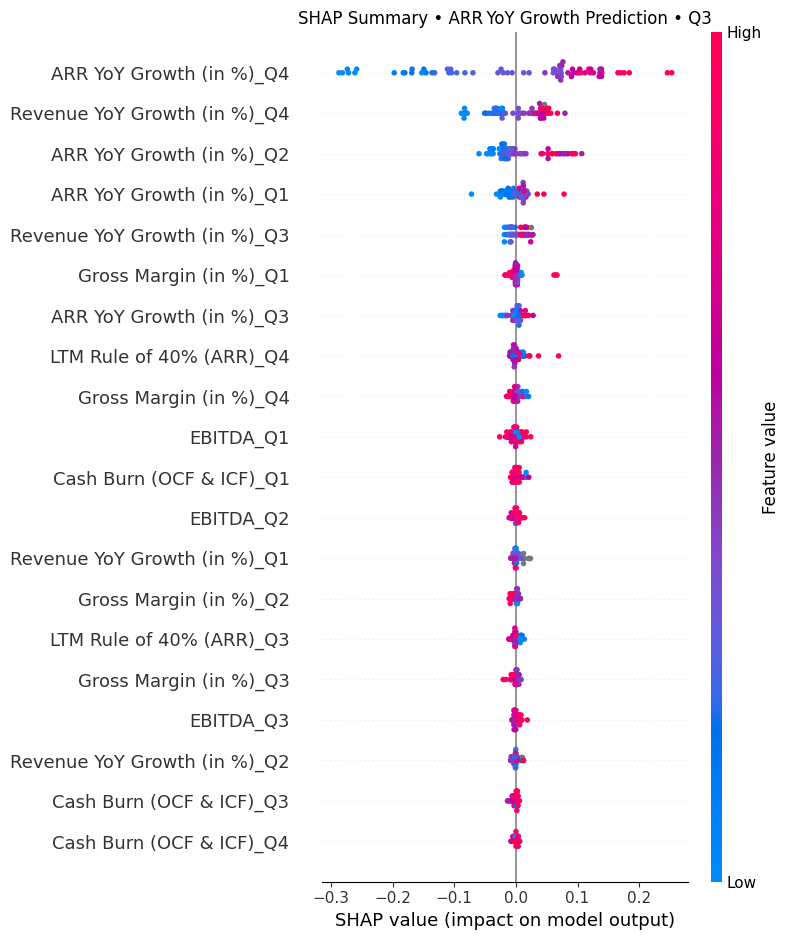

—— Q4: SHAP feature impact ——


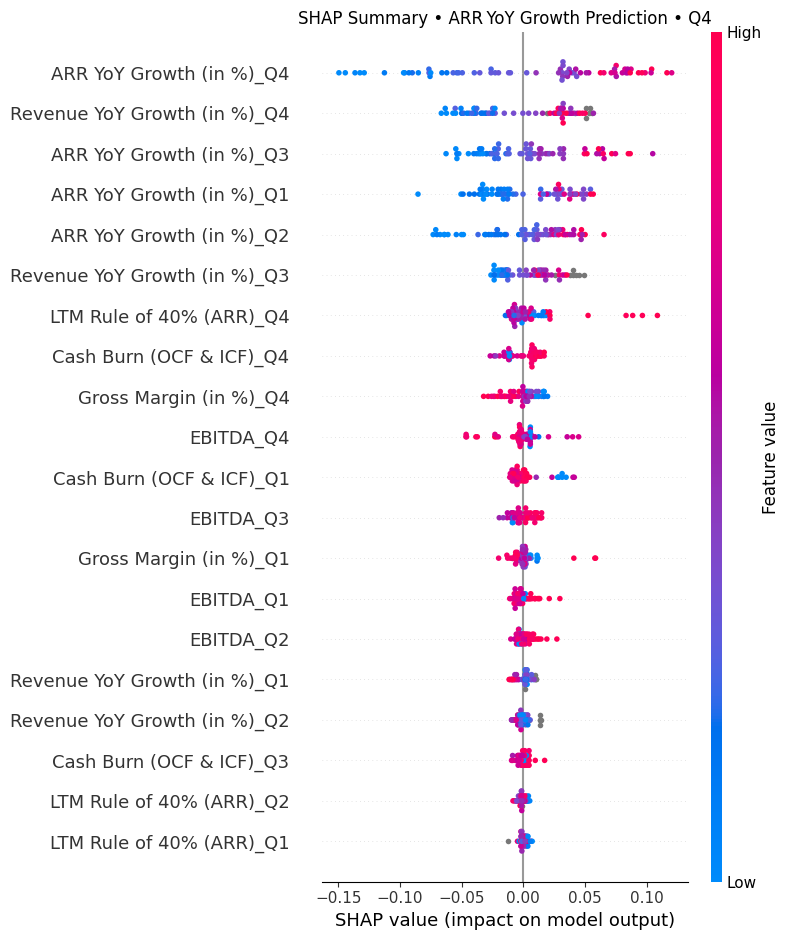

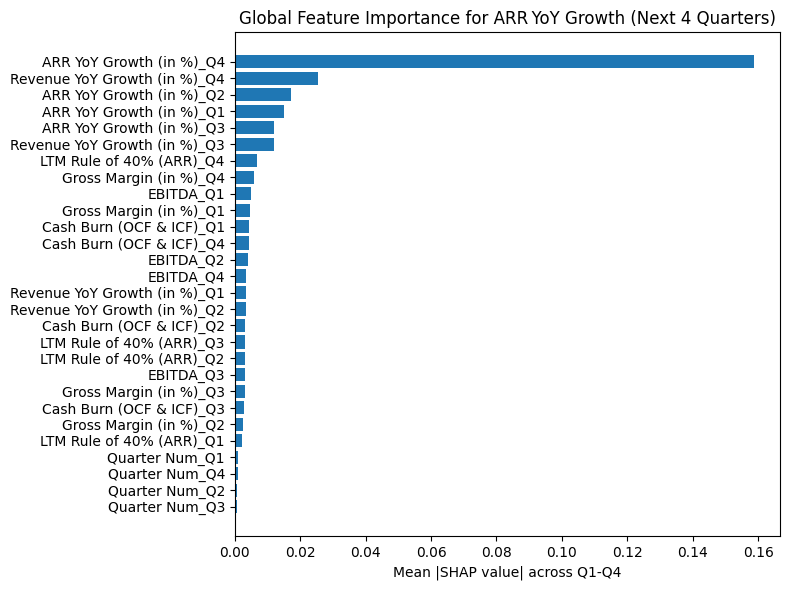

In [ ]:
# -------------------------------------------------------------
#   SHAP Explainability for Multi‑Output Random‑Forest
# -------------------------------------------------------------
# 0) install & import ------------------------------------------------------
try:
    import shap
except ImportError:
    !pip install --quiet shap
    import shap

import matplotlib.pyplot as plt
import numpy as np

shap.initjs()                   # enables JS plots in Jupyter

# 1) create a light background sample -------------------------
bg_size = min(200, len(X_train_global))     # safety for small datasets
background = X_train_global.sample(bg_size, random_state=42)

# 2) compute SHAP per‑quarter --------------------------------
quarter_names   = ["Q1", "Q2", "Q3", "Q4"]
shap_values_all = []                           # list to collect per‑target arrays

for i, q in enumerate(quarter_names):
    # grab the i‑th RandomForestRegressor
    rf_est = model_global.estimators_[i]

    # TreeExplainer with interventional perturbation
    explainer = shap.TreeExplainer(
        rf_est,
        background,
        feature_perturbation="interventional"
    )

    # calculate SHAP for the full test set
    shap_vals_q = explainer.shap_values(
        X_test_global,
        check_additivity=False   # <- avoids numeric‑precision assertion
    )
    shap_values_all.append(np.asarray(shap_vals_q))   # store for global view

    # interactive summary plot
    print(f"—— {q}: SHAP feature impact ——")
    shap.summary_plot(
        shap_vals_q,
        X_test_global,
        feature_names=X_test_global.columns,
        show=False                # prevent auto‑blocking
    )
    plt.title(f"SHAP Summary • ARR YoY Growth Prediction • {q}")
    plt.tight_layout()
    plt.show()

# 3) GLOBAL importance (mean(|SHAP|) over all four outputs) ---
abs_shap = [np.abs(sv) for sv in shap_values_all]          # list of arrays
mean_abs = np.mean(np.stack(abs_shap, axis=0), axis=0)     # avg across Q1‑Q4
global_imp = mean_abs.mean(axis=0)                         # → (n_features,)

# bar plot of global importance
plt.figure(figsize=(8, 6))
sorted_idx = np.argsort(global_imp)[::-1]                  # descending
plt.barh(range(len(sorted_idx)), global_imp[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test_global.columns[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value| across Q1‑Q4")
plt.title("Global Feature Importance for ARR YoY Growth (Next 4 Quarters)")
plt.tight_layout()
plt.show()

# 4) (optional) investigate a single prediction --------------
# idx = 0  # choose any row index from X_test_global
# shap.force_plot(
#     explainer.expected_value,
#     shap_values_all[0][idx],   # SHAP values for Q1; change 0‑3 for Q2‑Q4
#     X_test_global.iloc[idx],
#     matplotlib=True
# )




* Lagged ARR growth drives the forecast—especially last year’s Q4 (intuitive seasonal momentum).

* Revenue growth Q4 is almost as influential, confirming topline acceleration matters.

* Rule‑of‑40 and Cash‑Burn in Q4 matter, but their SHAP dots cross zero: high burn can either hurt or help depending on the company’s growth profile.

* Margins and EBITDA lag, showing smaller and more bidirectional effects—important, but secondary levers.


# New data for Algorithm

In [ ]:
# ================================================================
# ONE‑STOP CELL (95 % prediction bands)
# • Edit only the `company_df` block and `latest_arr`
# • Run the cell → prints plain‑English forecast with 95 % intervals
# ================================================================

import pandas as pd
import numpy as np

# ----------------------------------------------------------------
# 0)  ►►  EDIT YOUR 4‑ROW SNAPSHOT + baseline ARR HERE  ◄◄
# ----------------------------------------------------------------
company_df = pd.DataFrame({
    "id_company"                : ["Yalla Habibi"] * 4,
    "Financial Quarter"         : ["FY24 Q1", "FY24 Q2", "FY24 Q3", "FY24 Q4"],
    "ARR YoY Growth (in %)"     : [45, 48, 50, 55],
    "Revenue YoY Growth (in %)" : [40, 42, 46, 49],
    "Gross Margin (in %)"       : [68, 67, 66, 65],
    "EBITDA"                    : [-500_000, -450_000, -400_000, -350_000],
    "Cash Burn (OCF & ICF)"     : [-900_000, -850_000, -800_000, -750_000],
    "LTM Rule of 40% (ARR)"     : [85, 88, 90, 95]
})
latest_arr = 8_200_000   # € — most recent absolute ARR

# ----------------------------------------------------------------
# 1) Helper – mirror training pipeline & predict next year
# ----------------------------------------------------------------
def predict_next_year_df(model, ref_columns, df_raw, latest_arr=None):
    df = df_raw.copy()

    # Quarter parsing
    df['Year'] = df['Financial Quarter'].str.extract(r'FY(\d{2,4})')[0].astype(int)
    df['Year'] = df['Year'].apply(lambda x: x + 2000 if x < 100 else x)
    df['Quarter Num'] = df['Financial Quarter'].str.extract(r'(Q[1-4])')[0] \
                                               .map({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})
    df['Quarter Order'] = (df['Year'] - 2000) * 4 + df['Quarter Num']
    df = df.sort_values(['id_company', 'Quarter Order']).reset_index(drop=True)

    # Column subset + median impute
    sel = ['id_company', 'Quarter Order', 'ARR YoY Growth (in %)',
           'Revenue YoY Growth (in %)', 'Gross Margin (in %)',
           'EBITDA', 'Cash Burn (OCF & ICF)', 'LTM Rule of 40% (ARR)',
           'Quarter Num']
    df = df[sel].copy()
    for c in sel:
        if c not in ['id_company', 'Quarter Order']:
            df[c] = df.groupby('id_company')[c].transform(lambda s: s.fillna(s.median()))

    # Flatten 4 quarters → one row
    row = df.drop(columns=['id_company', 'Quarter Order']).values.flatten()
    X_single = pd.DataFrame([row], columns=ref_columns)
    for c in X_single.select_dtypes(include=['object']).columns:
        X_single[c] = X_single[c].astype('category').cat.codes

    growth = model.predict(X_single)[0]          # % for Q1‑Q4

    # Absolute ARR projection
    arr = None
    if latest_arr is not None:
        arr, curr = [], latest_arr
        for g in growth:
            curr *= (1 + g / 100)
            arr.append(curr)
        arr = np.array(arr)

    return growth, arr, X_single


# ----------------------------------------------------------------
# 2) Helper – 95 % prediction bands via tree dispersion
# ----------------------------------------------------------------
def rf_prediction_bands(multi_rf, x_row_df, alpha=0.05):     # α = 0.05 → 95 %
    rows = []
    x_np = x_row_df.values
    for i, q in enumerate(["Q1", "Q2", "Q3", "Q4"]):
        rf = multi_rf.estimators_[i]
        preds = np.array([t.predict(x_np)[0] for t in rf.estimators_])
        lo = np.percentile(preds, 100 * (alpha / 2))
        hi = np.percentile(preds, 100 * (1 - alpha / 2))
        rows.append({"Quarter": q,
                     "pred": rf.predict(x_row_df)[0],
                     "lo": lo, "hi": hi})
    return pd.DataFrame(rows).set_index("Quarter")


# ----------------------------------------------------------------
# 3) Forecast + bands + narrative print
# ----------------------------------------------------------------
growth, arr_mid, X_single = predict_next_year_df(
    model=model_global,
    ref_columns=X_global.columns,
    df_raw=company_df,
    latest_arr=latest_arr
)

bands = rf_prediction_bands(model_global, X_single, alpha=0.05)  # 95 % bands

# Propagate bands to ARR €
arr_low, arr_high = [], []
curr_lo = curr_hi = latest_arr
for q in ["Q1", "Q2", "Q3", "Q4"]:
    g_lo, g_hi = bands.loc[q, ["lo", "hi"]]
    curr_lo *= 1 + g_lo / 100
    curr_hi *= 1 + g_hi / 100
    arr_low.append(curr_lo)
    arr_high.append(curr_hi)

# --- Print plain‑English summary --------------------------------
print("### Forecast with 95 % prediction intervals\n")
for i, q in enumerate(["Q1", "Q2", "Q3", "Q4"]):
    g_mid = bands.loc[q, "pred"]
    g_lo  = bands.loc[q, "lo"]
    g_hi  = bands.loc[q, "hi"]
    print(f"{q}: ≈ {g_mid:.1f}% YoY growth — ARR expected to reach "
          f"≈ €{arr_mid[i]/1e6:.2f} M "
          f"(95 % range: {g_lo:.1f}%–{g_hi:.1f}%, i.e. "
          f"€{arr_low[i]/1e6:.2f} M–€{arr_high[i]/1e6:.2f} M)")


### Forecast with 95 % prediction intervals

Q1: ≈ 2.3% YoY growth — ARR expected to reach ≈ €8.39 M (95 % range: 1.3%–2.9%, i.e. €8.30 M–€8.44 M)
Q2: ≈ 1.8% YoY growth — ARR expected to reach ≈ €8.54 M (95 % range: 1.0%–2.1%, i.e. €8.38 M–€8.62 M)
Q3: ≈ 1.5% YoY growth — ARR expected to reach ≈ €8.67 M (95 % range: 0.5%–2.0%, i.e. €8.43 M–€8.80 M)
Q4: ≈ 1.4% YoY growth — ARR expected to reach ≈ €8.79 M (95 % range: 0.5%–2.1%, i.e. €8.47 M–€8.99 M)
